In [1]:
import full_model
import fast_model
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from joblib import Parallel, delayed

In [2]:
def generate_and_find_inf(num_nodes, steps, num_influencers=0):

    G = nx.barabasi_albert_graph(num_nodes, 2)

    model_inf = fast_model.InfluenceDeinfluenceModel(G)
    model_inf.set_initial_states()
    initial_influencers = model_inf.greedy_hill_climbing(num_influencers, steps)

    #initial_influencers = model_inf.greedy_hill_climbing_new(num_influencers)
    print("Optimized Initial Influencers:", initial_influencers)

    return model_inf, initial_influencers

In [3]:
# Example usage
num_nodes = 200
inf_steps = 10
num_influencers = 10

results = generate_and_find_inf(num_nodes, inf_steps, num_influencers=num_influencers)

(model_inf, optimized_influencers) = results

#print("count influence", model.evaluate_influence())

Optimized Initial Influencers: {128, 38, 169, 138, 78, 111, 178, 85, 28, 127}


In [10]:
deinf_steps = 3
deinf_num = 3

model = full_model.InfluenceDeinfluenceModel(model_inf.graph)
model.history = []
model.selected_influencers = optimized_influencers
print("Optimized Influencers:", optimized_influencers)

model.set_initial_states()
deinfluencers = model.greedy_hill_climbing_deinf(deinf_num, 20)
print("Optimized Deinfluencers:", deinfluencers)
model.reset_graph()
model.set_influencers(optimized_influencers)
model.set_deinfluencers(deinfluencers)
model.run_cascade(deinf_steps)
model.display_graphs_grid()

# print("count deinfuence",model.count_deinfluenced())

Optimized Influencers: {128, 38, 169, 138, 78, 111, 178, 85, 28, 127}


In [11]:
print(model.selected_influencers)
print(model.select_deinfluencers_from_influencers(3))

{128, 38, 169, 138, 78, 111, 178, 85, 28, 127}
[111, 78, 178]


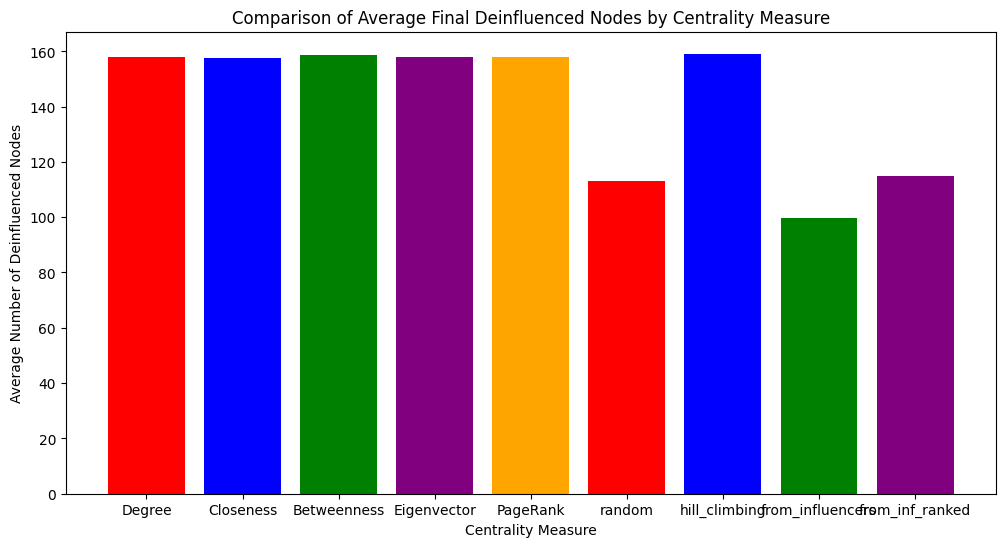

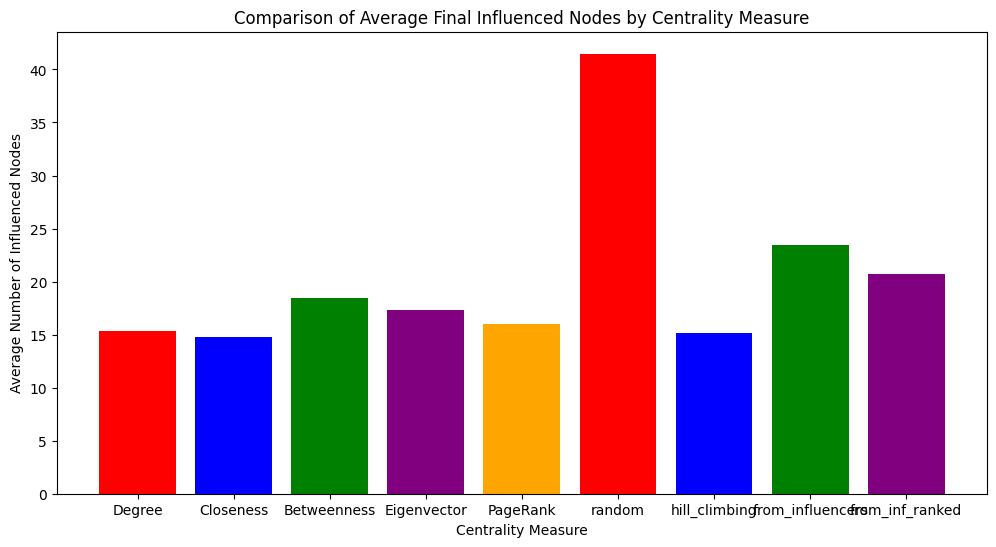

In [19]:
# Function to run the cascade and count deinfluenced nodes
def count_deinfluenced(model, inf, deinf, num_runs, steps):
    total_deinfluenced = 0
    for run in range(num_runs):
        model.reset_graph()
        model.set_influencers(inf)
        model.set_deinfluencers(deinf)
        model.run_cascade(steps)
        #print(model.history)
        deinfluenced_count = model.count_deinfluenced()
        #print(deinfluenced_count)
        #print(f"Run {run+1}/{num_runs}: {deinfluenced_count} nodes deinfluenced")
        total_deinfluenced += deinfluenced_count
        #print(f"Total deinfluenced nodes: {total_deinfluenced}")
        model.reset_graph()
        
    average_deinfluenced = total_deinfluenced / num_runs
    #print(f"Average deinfluenced nodes: {average_deinfluenced}")

    return average_deinfluenced

def count_influenced(model, inf, deinf, num_runs, steps):
    total_influenced = 0
    for run in range(num_runs):
        model.reset_graph()
        model.set_influencers(inf)
        model.set_deinfluencers(deinf)
        model.run_cascade(steps)
        #print(model.history)
        influenced_count = model.evaluate_influence()
        #print(deinfluenced_count)
        #print(f"Run {run+1}/{num_runs}: {deinfluenced_count} nodes deinfluenced")
        total_influenced += influenced_count
        #print(f"Total deinfluenced nodes: {total_deinfluenced}")
        model.reset_graph()
        
    average_influenced = total_influenced / num_runs
    #print(f"Average deinfluenced nodes: {average_deinfluenced}")

    return average_influenced

# Initialize the model
model.reset_graph()

# Rank nodes using different centrality measures
k_deinfluencers = 6

degree_centrality_ranking = model.select_deinfluencers_degree_centrality(k_deinfluencers)
closeness_centrality_ranking = model.select_deinfluencers_closeness_centrality(k_deinfluencers)
betweenness_centrality_ranking = model.select_deinfluencers_betweenness_centrality(k_deinfluencers)
eigenvector_centrality_ranking = model.select_deinfluencers_eigenvector_centrality(k_deinfluencers, max_iter=1000, tol=1e-06)
pagerank_centrality_ranking = model.select_deinfluencers_pagerank_centrality(k_deinfluencers)
random_deinfluencers = model.select_deinfluencers_random(k_deinfluencers)
optimized_deinfluencers = model.greedy_hill_climbing_deinf(k_deinfluencers, 5, 10)
deinfleucers_from_influencers = model.select_deinfluencers_from_influencers(j=k_deinfluencers)
ranked_deinfleucers_from_influencers = model.select_deinfluencers_from_influencers_degree_centrality(k_deinfluencers)


# print("Optimized Deinfluencers:", optimized_deinfluencers)
# print("Deinfluencers from Influencers:", deinfleucers_from_influencers)

# print("Degree Centrality Ranking:", degree_centrality_ranking)
# print("Closeness Centrality Ranking:", closeness_centrality_ranking)
# print("Betweenness Centrality Ranking:", betweenness_centrality_ranking)
# print("Eigenvector Centrality Ranking:", eigenvector_centrality_ranking)
# print("PageRank Centrality Ranking:", pagerank_centrality_ranking)
# print("Random Deinfluencers:", random_deinfluencers)


# Run cascades and count deinfluenced nodes for each centrality measure
num_runs = 10  # Number of times to run the cascade for averaging
steps = 3  # Number of steps to run the cascade

results_d = {
    'Degree': count_deinfluenced(model, optimized_influencers, degree_centrality_ranking, num_runs, steps),
    'Closeness': count_deinfluenced(model, optimized_influencers, closeness_centrality_ranking, num_runs, steps),
    'Betweenness': count_deinfluenced(model, optimized_influencers, betweenness_centrality_ranking, num_runs, steps),
    'Eigenvector': count_deinfluenced(model, optimized_influencers, eigenvector_centrality_ranking, num_runs, steps),
    'PageRank': count_deinfluenced(model, optimized_influencers, pagerank_centrality_ranking, num_runs, steps),
    'random': count_deinfluenced(model, optimized_influencers, random_deinfluencers, num_runs, steps),
    'hill_climbing': count_deinfluenced(model, optimized_influencers, optimized_deinfluencers, num_runs, steps),
    'from_influencers': count_deinfluenced(model, optimized_influencers, deinfleucers_from_influencers, num_runs, steps),
    'from_inf_ranked': count_deinfluenced(model, optimized_influencers, ranked_deinfleucers_from_influencers, num_runs, steps)
}

results_i = { 
    'Degree': count_influenced(model, optimized_influencers, degree_centrality_ranking, num_runs, steps),
    'Closeness': count_influenced(model, optimized_influencers, closeness_centrality_ranking, num_runs, steps),
    'Betweenness': count_influenced(model, optimized_influencers, betweenness_centrality_ranking, num_runs, steps),
    'Eigenvector': count_influenced(model, optimized_influencers, eigenvector_centrality_ranking, num_runs, steps),
    'PageRank': count_influenced(model, optimized_influencers, pagerank_centrality_ranking, num_runs, steps),
    'random': count_influenced(model, optimized_influencers, random_deinfluencers, num_runs, steps),
    'hill_climbing': count_influenced(model, optimized_influencers, optimized_deinfluencers, num_runs, steps),
    'from_influencers': count_influenced(model, optimized_influencers, deinfleucers_from_influencers, num_runs, steps),
    'from_inf_ranked': count_influenced(model, optimized_influencers, ranked_deinfleucers_from_influencers, num_runs, steps)
}



# Print the results
#for centrality, count in results.items():
    #print(f"{centrality}: {count:.2f} nodes deinfluenced on average")

# Plot the results
plt.figure(figsize=(12, 6))  # Increase the figure size
plt.bar(results_d.keys(), results_d.values(), color=['red', 'blue', 'green', 'purple', 'orange'])
plt.xlabel('Centrality Measure')
plt.ylabel('Average Number of Deinfluenced Nodes')
plt.title('Comparison of Average Final Deinfluenced Nodes by Centrality Measure')
plt.show()

plt.figure(figsize=(12, 6))  # Increase the figure size
plt.bar(results_i.keys(), results_i.values(), color=['red', 'blue', 'green', 'purple', 'orange'])
plt.xlabel('Centrality Measure')
plt.ylabel('Average Number of Influenced Nodes')
plt.title('Comparison of Average Final Influenced Nodes by Centrality Measure')
plt.show()


In [7]:

# # Initialize an empty dictionary to store the aggregated results
# aggregated_results = []

# # Run the simulation k times
# for i in range(10):
#     # Reset the graph and set the influencers
#     model.reset_graph()
#     model.set_influencers(optimized_influencers)
    
#     # Run the cascade and count deinfluenced nodes
#     result = count_deinfluenced(model, optimized_influencers, degree_centrality_ranking, num_runs, steps)
    
#     # Store the result in the aggregated_results dictionary
#     aggregated_results.append(result)

# print("Aggregated Results:", aggregated_results)

# # Plot the aggregated results

# plt.figure(figsize=(10, 6))  # Increase the figure size
# for i, result in enumerate(aggregated_results):
#     plt.bar(i, result, color='blue', alpha=0.5)
# plt.xlabel('Simulation')
# plt.ylabel('Average Number of Deinfluenced Nodes')
# plt.title('Aggregated Results of Multiple Simulations')
# plt.show()